# Factor Analysis EM

This notebook shows the multivariate extension of hidden state estimation from Chapter 2.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 3 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from numpy.linalg import inv
from numpy import diag
from pylab import colorbar
from scipy.stats import multivariate_normal, zscore
from types import SimpleNamespace

mpl.style.use("seaborn-deep")

In the final piece of this chapter we combine (multivariate) learning and inference together. Namely, we are interested in the following relationship among variables:

| Variable | Status     | Data type     |
|----------|------------|---------------|
| $x$      | unobserved | probabilistic |
| $y$      | observed   | probabilistic |
| $\Theta$ | unobserved | deterministic |
| $\phi$   | unobserved | deterministic |

Although for this example, the only unknown in $\phi$ will be the covariance matrix on $y$. This setup presents a problem. If everything is unknown how do we ever "get off the ground"? If $x$ is unobserved we can't perform inference because we don't know the parameters. But if we want to learn the parameters we cannot do that either because we have not yet observed $x$. The expectation maximization algorithm provides a way around this problem and is explained in much more detail in the text. The problem description is given in the text and copied directly here:

> For this experiment, consider an agent located at the origin of a grid that is trying to determine the 2D coordinates of a piece of food, similar to Experiment 3G. An agent, in position $(-0.5 , 0.5)$, has just heard a rival conspecific kill a prey, located at the origin. The agent decides it wants to steal the food but unfortunately, cannot see where the rival and dead prey are. Meanwhile, the rival is prowling around the dead prey at the origin trying to find the agent. Every so often it stops for a moment. Consider these stopping coordinates $\boldsymbol{x}_i \in \mathbb{R}^2$ which is a 2-dimensional vector denoting the position of the rival on the grid. When the rival moves to and from the stop locations it rustles the grass and makes a sound. At this position, the combination of states interacts within the environment in such a way that various observations $\boldsymbol{y}_i \in \mathbb{R}^8$ can be detected by the agent. The eight elements within this vector may be thought of different types of physical quantities the agent can sense or measure such as light, sound, vibrations on the ground, and so on. Thus in this system, samples of a noisy state vector $\boldsymbol{x}_i$ interact with a mixing matrix $\boldsymbol{\Theta}$ to produce a noisy observation vector $\boldsymbol{y}_i$. 

> The agent's goal is to use the noisy observation vector to infer the area around which the rival is circling so it can steal its prey. However, the agent does not already know from prior learning how the states mix to form the observations ($\boldsymbol{\Theta}$ is unknown) nor does it know the noise in the generation of $\boldsymbol{y}_i$ ($\boldsymbol{\Sigma}_y$) is unknown. Thus, the agent's must learn these model parameters from the data alongside estimating the hidden state. To learn these model parameters, the agent will initialize with a random guess and then iteratively update using the EM algorithm. 


First, let's create our environment. We will need to construct a vector $\boldsymbol{x} \in \mathbb{R}^{C=2}$ which generates $\boldsymbol{y} \in \mathbb{R}^{D=2}$ through the linear model. We will use 100 samples in our example.

In [2]:
class StaticEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def _noise(self, cov: float, dim: int):
        return multivariate_normal.rvs(mean=np.zeros(dim), cov=cov)
    
    def _generating_function(self, x_star: np.ndarray) -> float:
        return self.params.Theta_star @ x_star + self.params.b_star
    
    def generate(self, x_star: float) -> float:
        x_noise = self._noise(cov=self.params.cov_x_star, dim=self.params.C)
        y_noise = self._noise(cov=self.params.cov_y_star, dim=self.params.D)
        
        # Noise-ify external states and generate noisy y
        self.x_star_noise = x_star + x_noise
        return self._generating_function(self.x_star_noise) + y_noise

In [9]:
""" Environment parameters """
C = 2    # External state dimension
D = 8    # Data dimension
N = 50  # Number of samples

cov_y_star = np.random.normal(0, 1, D) * np.eye(D)    # Random covariance matrix
cov_y_star = cov_y_star @ cov_y_star.T                # Make positive semi-definite

env_params = {
    "C"           : C,                                # External state dimension   [D]
    "D"           : D,                                # Data dimension             [C]
    "Theta_star"  : np.random.normal(0, 5, (D, C)),   # Mixing matrix              [D X C]
    "cov_x_star"  : np.eye(2),                        # External states cov matrix [C x C]
    "cov_y_star"  : cov_y_star,                       # Sensory data cov matrox    [D x D]
    "b_star"      : 0,                                # Offset                     [1 x D]
}

# Initialize environment with parameters
env = StaticEnvironment(params=env_params)

# Generate N samples of data data
x_star  = np.array([0.4, 0.6])    # External state
Y       = np.zeros((N, D))        # Empty array for N data samples [D x 1]

for idx in range(N):
    Y[idx] = env.generate(x_star)

Y = zscore(Y)

To perform the EM algorithm, we first need to randomly initialize the two unknown parameters, $\boldsymbol{\Theta}$ and $\boldsymbol{\Sigma}_y$. Then, over $100$ iterations we first perform the **E-step**:

$$
\begin{aligned}
    \boldsymbol{\mu}_{x \mid y}^{(j)} &\leftarrow \underbrace{\boldsymbol{\Theta}^\top(\boldsymbol{\Theta} \boldsymbol{\Theta}^\top + \boldsymbol{\Sigma}_y)^{-1}}_{\beta}\boldsymbol{Y} \\
    \boldsymbol{\Sigma}_{x \mid y}^{(j)} &\leftarrow \boldsymbol{I} - \beta \boldsymbol{\Theta},
\end{aligned}
$$

followed by the **M-step**:

$$
\begin{aligned}
    \boldsymbol{\Theta}^{(j+1)} &\leftarrow \underbrace{\boldsymbol{Y} \boldsymbol{\mu}_{x \mid y}^\top}_{\delta} {\underbrace{(\boldsymbol{\mu}_{x \mid y} \boldsymbol{\mu}_{x \mid y}^\top + N \boldsymbol{\Sigma}_{x \mid y})}_{\gamma}}^{-1} \\
    \boldsymbol{\Sigma}_y^{(j+1)} &\leftarrow diag(Cov(\boldsymbol{Y}) - \frac{\boldsymbol{\Theta} \delta^\top}{N})
\end{aligned}
$$

These rules are implemented in the code below.

In [10]:
class FactorAnalysisEMAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        # Convenience params for readability 
        C            = self.params.C   # Hidden state dimension
        D            = self.params.D   # Sensory data dimension
        self.J       = self.params.J   # Number of iterations       
        
        # Initialize empty arrays
        self.posterior_mean = np.zeros((self.J, C))
        self.posterior_cov  = np.zeros((self.J, C, C))
        self.Theta          = np.zeros((self.J, D, C))
        self.cov_y          = np.zeros((self.J, D, D))
        
        # Initialize parameters
        self.Theta[0] = self.params.Theta_init
        self.cov_y[0] = self.params.cov_y_init
        
    def _infer_states(self, Y, j):
        # E-step (Expectation)
        beta = self.Theta[j].T @ inv(self.Theta[j] @ self.Theta[j].T + self.cov_y[j])
        
        self.posterior_mean_s = beta @ Y
        self.posterior_cov[j]  = np.eye(C) - beta @ self.Theta[j]
        
        # Get average posterior mean over samples
        self.posterior_mean[j] = np.mean(self.posterior_mean_s, axis=1)
        
    def _learn_parameters(self, Y, j):
        
        # M-step (Maximization)
        delta = Y @ self.posterior_mean_s.T
        gamma = self.posterior_mean_s @ self.posterior_mean_s.T + (N * self.posterior_cov[j])
        
        if j+1 < self.J:
            self.Theta[j+1] = delta @ inv(gamma)
            self.cov_y[j+1] = diag(diag(self.S - (self.Theta[j+1] @ delta.T / N)))
        
    def run_EM(self, Y):
        
        self.S = np.cov(Y)   # Compute the sample covariance
        
        for j in range(self.J):
            self._infer_states(Y, j=j)
            self._learn_parameters(Y, j=j)

In [11]:
Theta_init = np.random.normal(0, 5, (D, C))           # Random mixing matrix
cov_y_init = np.random.normal(0, 1, D) * np.eye(D)    # Random covariance matrix
cov_y_init = cov_y_init @ cov_y_init.T                # Make positive semi-definite

agent_params = {
    "C"          : C,            # Dimension of hidden states
    "D"          : D,            # Dimension of sensory data
    "J"          : 100,          # Number of iterations
    "Theta_init" : Theta_init,   # Mixing matrix initialization
    "cov_y_init" : cov_y_init    # Covariance matrix of y initialization
}

agent = FactorAnalysisEMAgent(params=agent_params)
agent.run_EM(Y.T)

In [12]:
# Plot the belief about the true mean of x
print(f"Inferred mean: {agent.posterior_mean[-1]}")
print(f"Inferred covariance matrix: {agent.posterior_cov[-1]}")

Inferred mean: [-1.33226763e-17  2.22044605e-18]
Inferred covariance matrix: [[ 0.01215948 -0.00292741]
 [-0.00292741  0.002024  ]]


In [13]:
def create_grid(x_min, x_max):
    X_grid, y_grid = np.mgrid[x_min:x_max:.001, x_min:x_max:.001]
    grid = np.dstack((X_grid, y_grid))
    return grid

Text(0, 0.5, 'Vertical position')

<Figure size 432x288 with 0 Axes>

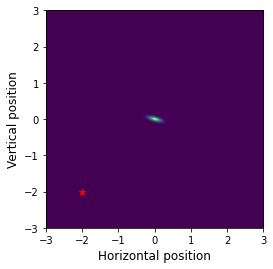

In [14]:
""" Plot the inferred probability of x"""
# Grid
x_min = -3
x_max = 3
grid = create_grid(x_min, x_max)

# p(x)_hat - inferred posterior
posterior_probs = multivariate_normal.pdf(grid, mean=agent.posterior_mean[-1], cov=agent.posterior_cov[-1])

# Plot
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

## Distribution
ax.imshow(posterior_probs.T, origin="lower", cmap="viridis", extent=[x_min, x_max, x_min, x_max])

## Agent location
ax.plot(-2, -2, marker="*", color="red", markersize=7)

ax.set_xlabel("Horizontal position", fontsize=12)
ax.set_ylabel("Vertical position", fontsize=12)